### EDA + Feature Engineering

In [1]:
# Setup

import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, LabelEncoder

print('Setup Complete')

Setup Complete


In [2]:
# Load Data

DATA_PATH = '../data/data.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# EDA

print('Shape: ', df.shape)
print(df.dtypes)
print(df.isnull().sum())
print(df['isFraud'].value_counts())
print('Fraud Ratio: ', df['isFraud'].mean())

Shape:  (6362620, 11)
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud Ratio:  0.001290820448180152


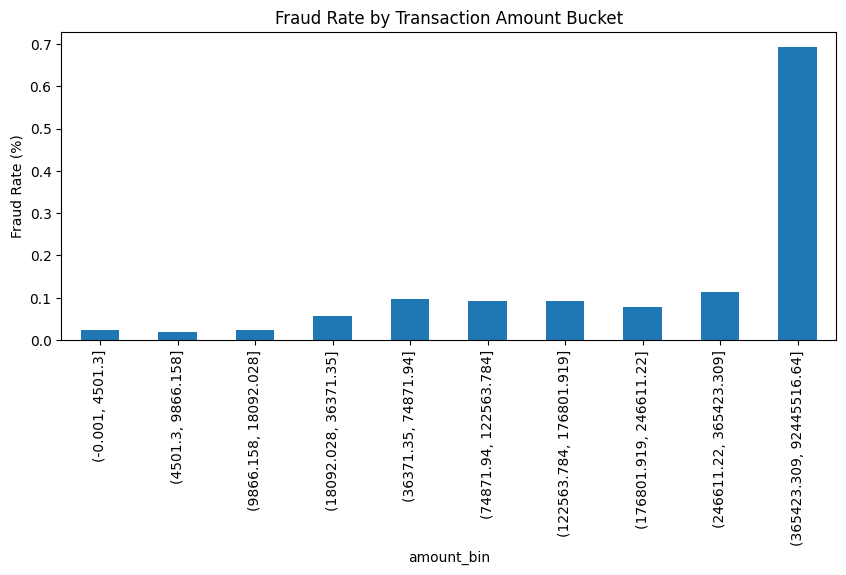

In [4]:
# Fraud Rate by Amount Bucket
df['amount_bin'] = pd.qcut(df['amount'], q=10, duplicates='drop')

fraud_rate = df.groupby('amount_bin')['isFraud'].mean()
fraud_rate = fraud_rate * 100

plt.figure(figsize=(10,4))
fraud_rate.plot(kind='bar')
plt.ylabel("Fraud Rate (%)")
plt.title('Fraud Rate by Transaction Amount Bucket')

plt.show()

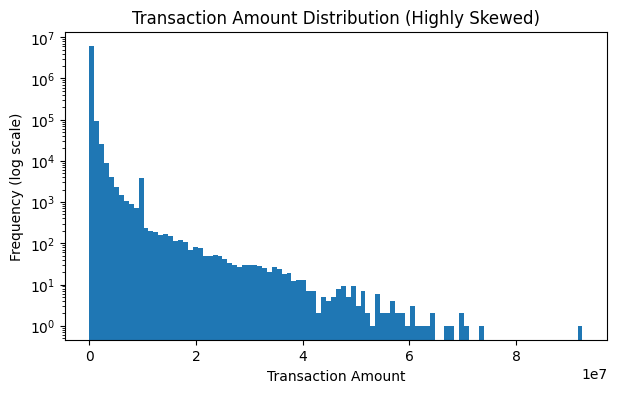

In [5]:
# Outlier Handling
df['amount'].describe()

#Visualize Skewness

plt.figure(figsize=(7,4))
plt.hist(df['amount'], bins=100)
plt.yscale('log')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log scale)')
plt.title('Transaction Amount Distribution (Highly Skewed)')
plt.show()

In [6]:
# Log transform to reduce skewness
df['log_amount'] = np.log1p(df['amount'])

# Flag transactions above 99th percentile
p99 = df['amount'].quantile(0.99)
df['is_high_amount'] = (df['amount'] > p99).astype(int)

df['is_high_amount'].value_counts()

is_high_amount
0    6298993
1      63627
Name: count, dtype: int64

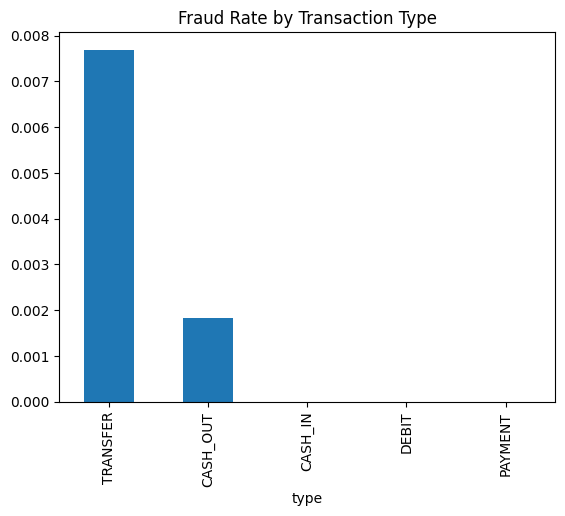

In [7]:
# Fraud Rate by Transaction Type
df.groupby('type')['isFraud'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Fraud Rate by Transaction Type')
plt.show()

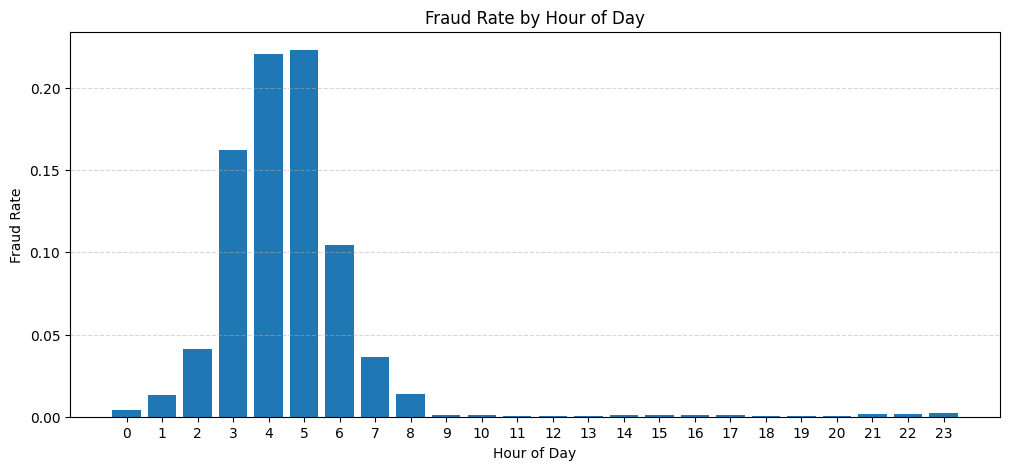

In [8]:
# Time-based overview

df['hour'] = df['step'] % 24
hourly_stats = (
    df.groupby('hour')
      .agg(
          total_transactions=('isFraud', 'count'),
          fraud_transactions=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean')
      )
      .reset_index()
)
# Fraud rate by hour

plt.figure(figsize=(12,5))
plt.bar(hourly_stats['hour'], hourly_stats['fraud_rate'])
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour of Day')
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

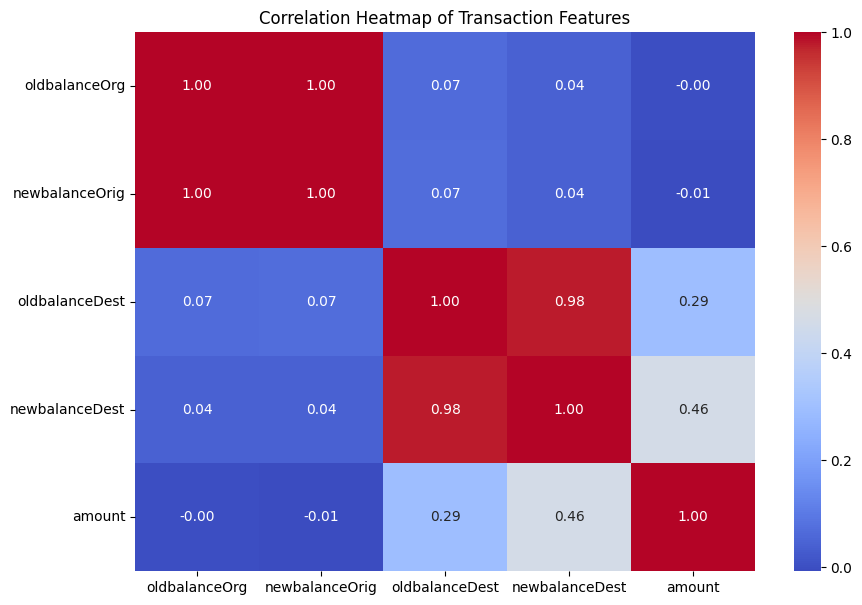

In [13]:
# Correlation Check

plt.figure(figsize=(10,7))
corr = df[['oldbalanceOrg','newbalanceOrig',
           'oldbalanceDest','newbalanceDest',
           'amount']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Transaction Features')
plt.show()

In [9]:
# Feature Engineering – Balance Differences
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Feature Reduction (for linear models here for logistic regression)
df = df.drop(columns=[
    'oldbalanceOrg',
    'newbalanceOrig',
    'oldbalanceDest',
    'newbalanceDest'
])

In [10]:
df.drop(columns=['amount_bin'], inplace=True)
df.fillna(0, inplace=True)

le = LabelEncoder()
df['type_enc'] = le.fit_transform(df['type'])

df.drop(['nameOrig', 'nameDest', 'type'], axis=1, inplace=True)

In [11]:
# Save processed data

df.to_csv('../data/processed_data.csv', index=False)

In [12]:
# Save sample data

sample = df.groupby('isFraud', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=42))
sample.to_csv('../data/sample.csv', index=False)
print(sample.shape)
print(sample['isFraud'].value_counts())

(63626, 10)
isFraud
0    63544
1       82
Name: count, dtype: int64


The EDA reveals that fraud is heavily concentrated in TRANSFER and CASH_OUT transaction types, with higher transaction amounts showing significantly elevated fraud likelihood. Balance difference features were engineered to capture suspicious fund movement patterns, replacing redundant pre and post transaction balance columns that showed severe multicollinearity. Given severe class imbalance, accuracy is misleading - a model predicting all transactions as legitimate would still achieve 99.87% accuracy. ROC-AUC, AUPRC, and fraud-class recall will be the primary evaluation metrics across all models.